# Visualizing Training Statistics with Tensorborad
PyTorch integrates with TensorBoard, a tool designed for visualizing the results of neural network training runs.

In this tutorial, we’ll learn how to:

- Set up TensorBoard.

- Write to TensorBoard.

- Inspect a model architecture using TensorBoard.

- Use TensorBoard to create interactive versions of the statistics visualizations (like loss, accuracy, etc..)

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    img = img.cpu()
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    
    to_pil = transforms.ToPILImage()
    
    if one_channel:
        npimg = img.numpy()
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(to_pil(img))

C:\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# let's define a model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = Net().to(device)

In [3]:
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

Now we’ll set up TensorBoard, importing tensorboard from <code>torch.utils</code> and defining a <code>SummaryWriter</code>, our key object for writing information to TensorBoard.

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./runs/fashion_mnist_experiment_2')

Now let’s write an image to our TensorBoard - specifically, a grid using <code>make_grid</code>.

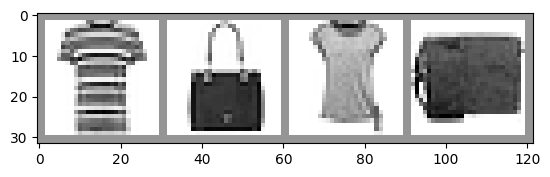

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

### Now lets run:
<code>tensorboard --logdir=runs</code>

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [6]:
writer.add_graph(net, images.to(device))
writer.close()

## Tracking Model Training

In [7]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s train the model using the usual model training code, but writing results to TensorBoard every 1000 batches instead of printing to console; this is done using the <code>add_scalar</code> function.

In [8]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

running_loss = 0.0
correct = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # put data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        correct += get_num_correct(outputs, labels)
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            # ...log the training accuracy
            writer.add_scalar('training accuracy',
                            correct / (1000*inputs.size(0)),
                            epoch * len(trainloader) + i)
            
            print('It: {} Loss: {} Accuracy: {}'.format(epoch * len(trainloader) + i, running_loss / 1000, correct / (1000*inputs.size(0))))

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            
            running_loss = 0.0
            correct = 0.0
writer.close()
print('Finished Training')

It: 999 Loss: 0.9105817513670772 Accuracy: 0.65075
It: 1999 Loss: 0.6015693995420588 Accuracy: 0.7645
It: 2999 Loss: 0.5558758871450554 Accuracy: 0.7935
It: 3999 Loss: 0.49088196047651583 Accuracy: 0.8185
It: 4999 Loss: 0.5038536311362405 Accuracy: 0.81775
It: 5999 Loss: 0.45384653298181 Accuracy: 0.83825
It: 6999 Loss: 0.43986416814578116 Accuracy: 0.84
It: 7999 Loss: 0.41592451179666384 Accuracy: 0.85
It: 8999 Loss: 0.4187983091714559 Accuracy: 0.84525
It: 9999 Loss: 0.3840220958087184 Accuracy: 0.86375
It: 10999 Loss: 0.39828716046893897 Accuracy: 0.8605
It: 11999 Loss: 0.38608326169229257 Accuracy: 0.85675
It: 12999 Loss: 0.39031023852447105 Accuracy: 0.859
It: 13999 Loss: 0.39958879092463756 Accuracy: 0.84875
It: 14999 Loss: 0.3680211321323332 Accuracy: 0.86775
Finished Training


In [9]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        output = net(images)
        class_probs_batch = [F.softmax(el.cpu(), dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels.cpu())

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)